In [31]:
#Importamos las librerias necesarias 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import pickle

from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statistics import mode
from sklearn.metrics import mean_squared_error

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate=False
logger.setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

In [32]:
# !pip install pmdarima

In [33]:
productos = pd.read_csv("./archivos_csv/product_act.csv")
ventas = pd.read_csv("./archivos_csv/ventas_total.csv")

In [34]:
ventas

id    total  gratuity  discounts    taxes  subtotal  \
0      4617000165572608   6990.0       0.0        0.0   1629.0    5361.0   
1      4878437089804288  17970.0       0.0        0.0   2868.0   15102.0   
2      5124727694426112   6990.0       0.0        0.0   1116.0    5874.0   
3      5246704765632512  19980.0       0.0    -3700.0   2599.0   17381.0   
4      5308026161201152  12880.0       0.0        0.0   2056.0   10824.0   
...                 ...      ...       ...        ...      ...       ...   
53599  6643010967306240  54930.0    5493.0        0.0   8769.0   46161.0   
53600  6683520360644608  86780.0    8678.0        0.0  13855.0   72925.0   
53601  6739510057631744  26170.0    2617.0        0.0   4178.0   21992.0   
53602  6740702414372864  21990.0       0.0        0.0   3511.0   18479.0   
53603  6750384411508736  26370.0    2636.0        0.0   4210.0   22160.0   

         payed table_id  waiter_id            date_open          date_closed  
0      10203.0  V-90002          0  2021-08-14T00:55:44  2021-08-14T01:50:47  
1      17970.0       18          3  2021-08-14T01:26:35  2021-08-14T20:23:29  
2       6990.0        7          3  2021-08-14T01:33:55  2021-08-14T01:42:23  
3      16280.0       16          3  2021-08-13T21:10:13  2021-08-13T21:26:44  
4      12880.0        3          3  2021-08-13T22:25:19  2021-08-14T00:04:35  
...        ...      ...        ...                  ...                  ...  
53599  60423.0       39         19  2024-02-10T23:27:32  2024-02-11T05:34:53  
53600  95458.0       36         19  2024-02-11T02:59:49  2024-02-11T05:36:28  
53601  28787.0       10         19  2024-02-11T02:13:53  2024-02-11T05:27:24  
53602  21990.0  V-90014          0  2024-02-11T01:52:18  2024-02-11T01:57:04  
53603  29006.0       34         16  2024-02-11T02:33:48  2024-02-11T03:36:22  

[53604 rows x 11 columns]

In [35]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53604 entries, 0 to 53603
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           53604 non-null  int64  
 1   total        53604 non-null  float64
 2   gratuity     53604 non-null  float64
 3   discounts    53604 non-null  float64
 4   taxes        53604 non-null  float64
 5   subtotal     53604 non-null  float64
 6   payed        53604 non-null  float64
 7   table_id     53604 non-null  object 
 8   waiter_id    53604 non-null  int64  
 9   date_open    53604 non-null  object 
 10  date_closed  53604 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [36]:
ventas.duplicated(subset=['id']).sum()

224

In [37]:
ventas.drop_duplicates(subset=['id'], inplace=True)

In [38]:
productos

order_id product_id  quantity    payed   taxes  discounts  \
0       4503601585848320       6650         1   4490.0   717.0        0.0   
1       4503645076586496       6870         1   3890.0   621.0        0.0   
2       4503645076586496       2650         1   4190.0   669.0        0.0   
3       4503645076586496       6870         1   3890.0   621.0        0.0   
4       4503645076586496       6590         1   6990.0  1116.0        0.0   
...                  ...        ...       ...      ...     ...        ...   
172793  6755396743200768       4351         1  12990.0  2074.0        0.0   
172794  6755396743200768       4680         1   4790.0   765.0        0.0   
172795  6755396743200768       4680         1   4790.0   765.0        0.0   
172796  6755396743200768       1390         1   2390.0   382.0        0.0   
172797  6755397736857600       1690         1   7490.0  1196.0        0.0   

                           producto  net_price hierarchy_id hierarchy  
0                        Mistral 35     4490.0       AB.075       Bar  
1                 Jugo de frambuesa     1422.0       AB.075       Bar  
2                    Schop heineken     2990.0       AB.085    Schops  
3                 Jugo de frambuesa     1422.0       AB.075       Bar  
4       Jhonnie Walker Black Label      6990.0       AB.075       Bar  
...                             ...        ...          ...       ...  
172793   choclo champiñon compartir        0.0       AB.530   PAPITAS  
172794                     Absolute     4990.0       AB.075       Bar  
172795                     Absolute     4990.0       AB.075       Bar  
172796                        fanta      990.0       AB.050  Drinks 🥤  
172797       Hamburguesa  Americana     6290.0       AB.020   Burgers  

[172798 rows x 10 columns]

In [39]:
productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172798 entries, 0 to 172797
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      172798 non-null  int64  
 1   product_id    172798 non-null  object 
 2   quantity      172798 non-null  int64  
 3   payed         172798 non-null  float64
 4   taxes         172798 non-null  float64
 5   discounts     172798 non-null  float64
 6   producto      172798 non-null  object 
 7   net_price     172798 non-null  float64
 8   hierarchy_id  172798 non-null  object 
 9   hierarchy     172798 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 13.2+ MB


In [40]:
df = pd.merge(productos, ventas[['id', 'date_open']], left_on='order_id', right_on='id', how='left')
df.drop('id', axis=1, inplace=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172798 entries, 0 to 172797
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      172798 non-null  int64  
 1   product_id    172798 non-null  object 
 2   quantity      172798 non-null  int64  
 3   payed         172798 non-null  float64
 4   taxes         172798 non-null  float64
 5   discounts     172798 non-null  float64
 6   producto      172798 non-null  object 
 7   net_price     172798 non-null  float64
 8   hierarchy_id  172798 non-null  object 
 9   hierarchy     172798 non-null  object 
 10  date_open     172798 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 14.5+ MB


In [42]:
# Convertir las columnas de fecha a datetime
df['date_open'] = pd.to_datetime(df['date_open'], format='%Y-%m-%dT%H:%M:%S').dt.date
df

order_id product_id  quantity    payed   taxes  discounts  \
0       4503601585848320       6650         1   4490.0   717.0        0.0   
1       4503645076586496       6870         1   3890.0   621.0        0.0   
2       4503645076586496       2650         1   4190.0   669.0        0.0   
3       4503645076586496       6870         1   3890.0   621.0        0.0   
4       4503645076586496       6590         1   6990.0  1116.0        0.0   
...                  ...        ...       ...      ...     ...        ...   
172793  6755396743200768       4351         1  12990.0  2074.0        0.0   
172794  6755396743200768       4680         1   4790.0   765.0        0.0   
172795  6755396743200768       4680         1   4790.0   765.0        0.0   
172796  6755396743200768       1390         1   2390.0   382.0        0.0   
172797  6755397736857600       1690         1   7490.0  1196.0        0.0   

                           producto  net_price hierarchy_id hierarchy  \
0                        Mistral 35     4490.0       AB.075       Bar   
1                 Jugo de frambuesa     1422.0       AB.075       Bar   
2                    Schop heineken     2990.0       AB.085    Schops   
3                 Jugo de frambuesa     1422.0       AB.075       Bar   
4       Jhonnie Walker Black Label      6990.0       AB.075       Bar   
...                             ...        ...          ...       ...   
172793   choclo champiñon compartir        0.0       AB.530   PAPITAS   
172794                     Absolute     4990.0       AB.075       Bar   
172795                     Absolute     4990.0       AB.075       Bar   
172796                        fanta      990.0       AB.050  Drinks 🥤   
172797       Hamburguesa  Americana     6290.0       AB.020   Burgers   

         date_open  
0       2023-01-24  
1       2023-03-17  
2       2023-03-17  
3       2023-03-17  
4       2023-03-17  
...            ...  
172793  2024-01-11  
172794  2024-01-11  
172795  2024-01-11  
172796  2024-01-11  
172797  2022-01-04  

[172798 rows x 11 columns]

In [43]:
df['producto'] = df['producto'].str.replace(r'\s+', ' ', regex=True)
df['producto'] = df['producto'].str.replace(r'\s+', ' ', regex=True).str.strip()
df = df[df['producto'] != 'Aparte']

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171560 entries, 0 to 172797
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      171560 non-null  int64  
 1   product_id    171560 non-null  object 
 2   quantity      171560 non-null  int64  
 3   payed         171560 non-null  float64
 4   taxes         171560 non-null  float64
 5   discounts     171560 non-null  float64
 6   producto      171560 non-null  object 
 7   net_price     171560 non-null  float64
 8   hierarchy_id  171560 non-null  object 
 9   hierarchy     171560 non-null  object 
 10  date_open     171560 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 15.7+ MB


In [45]:
df = df[['producto', 'date_open']]
df = df.rename(columns={
    'date_open': 'fecha'
})
df = df.sort_values(by='fecha', ascending=True)
df

producto       fecha
160012                         Costo Delivery  2021-08-13
141011                       veggie compartir  2021-08-13
56974    2 hamburguesas con papas + 2 bebidas  2021-08-13
56975   Hamburguesa Americana con papas promo  2021-08-13
56976         Hamburguesa Hot con papas promo  2021-08-13
...                                       ...         ...
77293                               Caipiriña  2024-02-11
77292                            Tropical gin  2024-02-11
49804                   Hamburguesa Americana  2024-02-11
49806                   Hamburguesa Americana  2024-02-11
171685                 beefie compartir promo  2024-02-11

[171560 rows x 2 columns]

In [46]:
df['fecha'] = pd.to_datetime(df['fecha'])
# Establecer la columna 'fecha' como el índice del DataFrame
df.set_index('fecha', inplace=True)
# Agrupar los datos por producto y semana, y contar las ventas para cada grupo
ventas_semanales = df.groupby(['producto', pd.Grouper(freq='W')]).size().reset_index(name='ventas_semanales')
# Ver las primeras filas del DataFrame resultante para verificar la agrupación y el conteo
ventas_semanales

producto      fecha  ventas_semanales
0              2 Black label 2023-01-22                 8
1                  2 Cacique 2023-02-19                 1
2                  2 Cacique 2023-03-05                 1
3                  2 Cacique 2023-08-06                 3
4      2 Cosmopolitan x 7990 2022-04-03                 4
...                      ...        ...               ...
17010      veggie individual 2024-01-14                 2
17011      veggie individual 2024-01-21                12
17012      veggie individual 2024-01-28                 7
17013      veggie individual 2024-02-04                 8
17014      veggie individual 2024-02-11                 6

[17015 rows x 3 columns]

In [47]:
# Identificar los productos que tienen al menos 104 registros semanales (2 años de datos semanales)
productos = ventas_semanales.groupby('producto').filter(lambda x: len(x) >= 104)['producto'].unique()
# Filtrar los datos para quedarnos solo con esos productos
df = ventas_semanales[ventas_semanales['producto'].isin(productos)]
df

producto      fecha  ventas_semanales
328     2 SCHOP HEINEKEN 2021-12-12                 2
329     2 SCHOP HEINEKEN 2021-12-19                24
330     2 SCHOP HEINEKEN 2021-12-26                 2
331     2 SCHOP HEINEKEN 2022-01-02                47
332     2 SCHOP HEINEKEN 2022-01-09                25
...                  ...        ...               ...
17010  veggie individual 2024-01-14                 2
17011  veggie individual 2024-01-21                12
17012  veggie individual 2024-01-28                 7
17013  veggie individual 2024-02-04                 8
17014  veggie individual 2024-02-11                 6

[9231 rows x 3 columns]

In [48]:
# Suponiendo que tu DataFrame se llama df
# Asegúrate de que tu DataFrame esté cargado correctamente aquí.
# Calcular el promedio de ventas semanales por producto
promedio_por_producto = df.groupby('producto')['ventas_semanales'].mean()
# Por ejemplo, establecer el umbral como el 25% percentil de los promedios de ventas
umbral = promedio_por_producto.quantile(0.5)
# Filtrar para obtener los productos con un promedio de ventas por debajo del umbral
productos_bajo_rendimiento = promedio_por_producto[promedio_por_producto < umbral].index.tolist()
# Mostrar los productos que se consideran de bajo rendimiento
productos_bajo_rendimiento

['Aperol Spritz',
 'Bacon',
 'Caipiriña',
 'Calypso',
 'Crema acida',
 'Guacamole',
 'Hamburguesa Americana con papas promo',
 'Hamburguesa Vegana',
 'Hamburguesa Vegetariana con papas promo',
 'Honey Mustard',
 'Jugo de frambuesa',
 'Jugo de mango',
 'Jugo de maracuya',
 'Lemon Garlic',
 'Limonada Menta Jengibre',
 'Limonada menta',
 'Margarita',
 'Moscow Mule',
 'Pebre',
 'Pisco Sour',
 'Salsa de la casa',
 'Salsa picante',
 'Tom Collins',
 'Vegetales salteados',
 'beefie compartir promo',
 'chicken curry compartir',
 'chicken curry individual',
 'choclo champiñon compartir promo',
 'fanta',
 'jugo durazno promo',
 'mechada compartir promo',
 'mexa individual',
 'pollo albahaca individual',
 'single fries individual',
 'sprite',
 'sprite promo',
 'veggie compartir promo',
 'veggie individual']

In [49]:
df= df[~df['producto'].isin(productos_bajo_rendimiento)]

In [50]:
df['producto'].nunique()

38

In [51]:
# Palabras clave para identificar los productos de comida
palabras_clave_comida = ['papas', 'individual', 'compartir', 'Hamburguesa', 'Chicken', 'Cheddar', 'Crema acida', 'Salsa','Vegetales salteados']
# Crear la cadena de consulta para comida
consulta_comida = " | ".join([f"producto.str.contains('{palabra}', case=False, na=False)" for palabra in palabras_clave_comida])
# Filtrar el DataFrame para obtener solo los productos de comida
df_comida = df.query(consulta_comida)
# Filtrar el DataFrame para obtener los productos que no son comida (tragos)
df_tragos = df.query(f"not ({consulta_comida})")

In [52]:
# Asegúrate de que df_comida y df_tragos son copias independientes para evitar la advertencia
df_comida = df_comida.copy()
df_tragos = df_tragos.copy()

# Asignar valores a la nueva columna 'semana_del_año' correctamente
df_comida['semana_del_año'] = df['fecha'].dt.isocalendar().week
df_tragos['semana_del_año'] = df['fecha'].dt.isocalendar().week

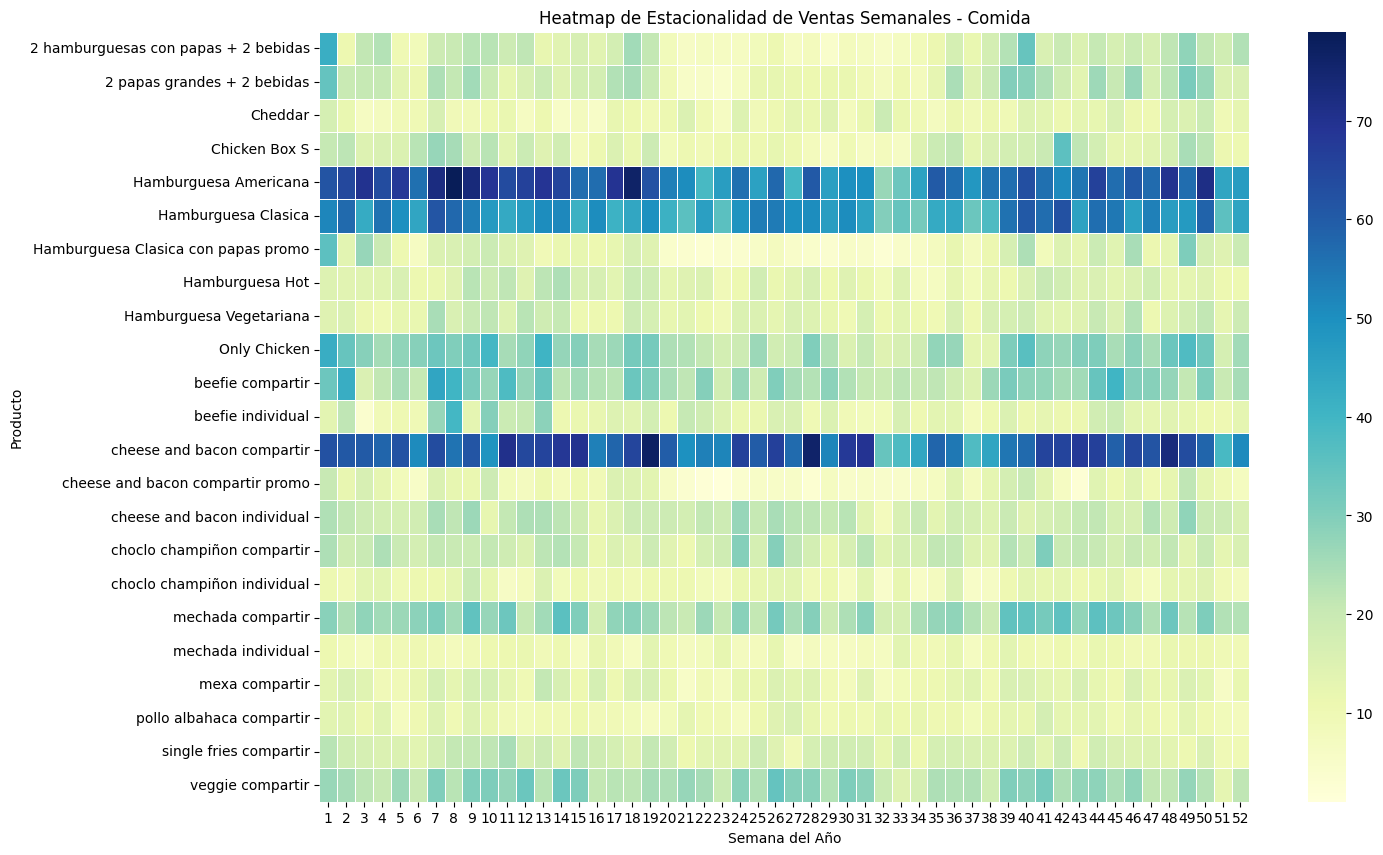

In [53]:
heatmap_data_comida = df_comida.groupby(['producto', 'semana_del_año']).ventas_semanales.mean().unstack()
# Crear el heatmap para comida
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_comida, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Semanales - Comida')
plt.ylabel('Producto')
plt.xlabel('Semana del Año')
plt.show()

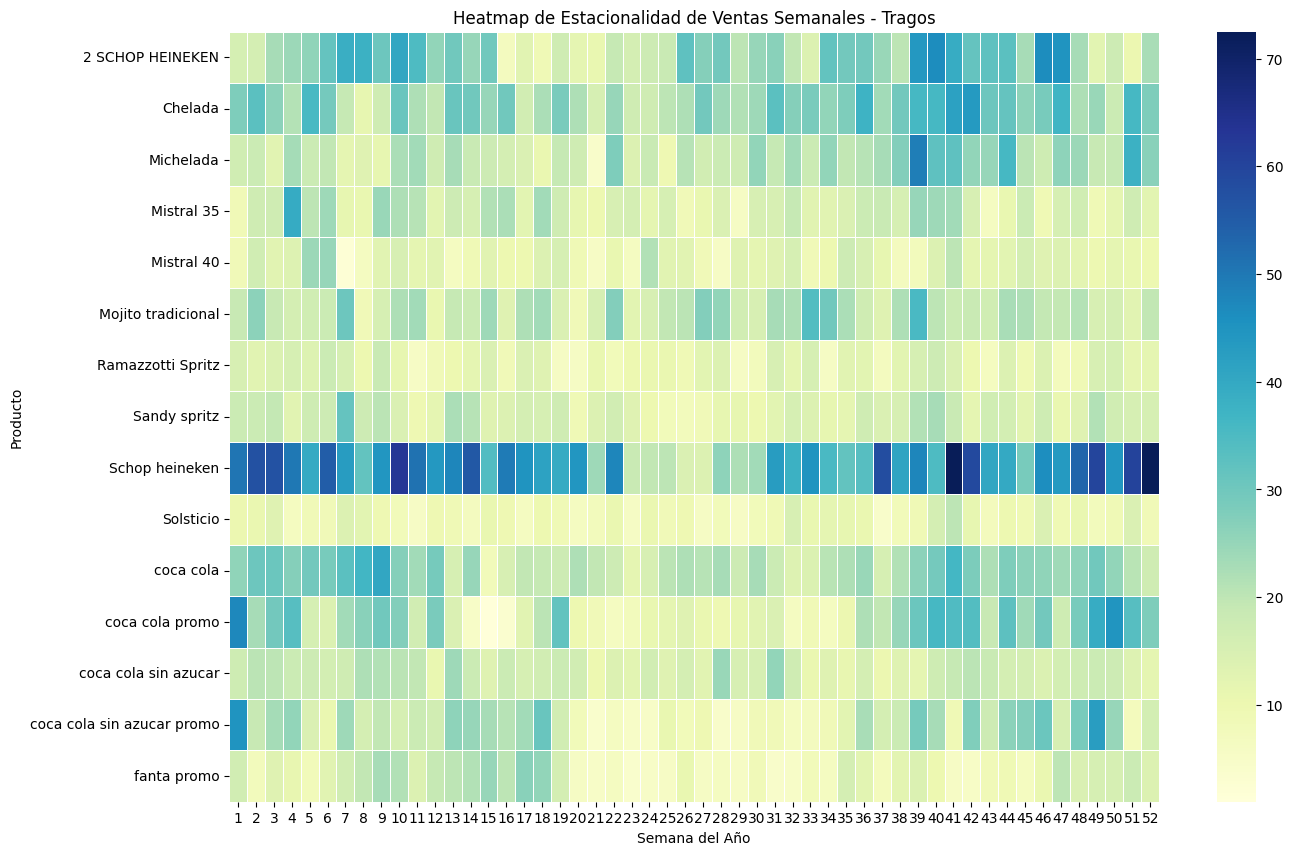

In [54]:
heatmap_data_tragos = df_tragos.groupby(['producto', 'semana_del_año']).ventas_semanales.mean().unstack()
# Crear el heatmap para tragos
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_tragos, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Semanales - Tragos')
plt.ylabel('Producto')
plt.xlabel('Semana del Año')
plt.show()

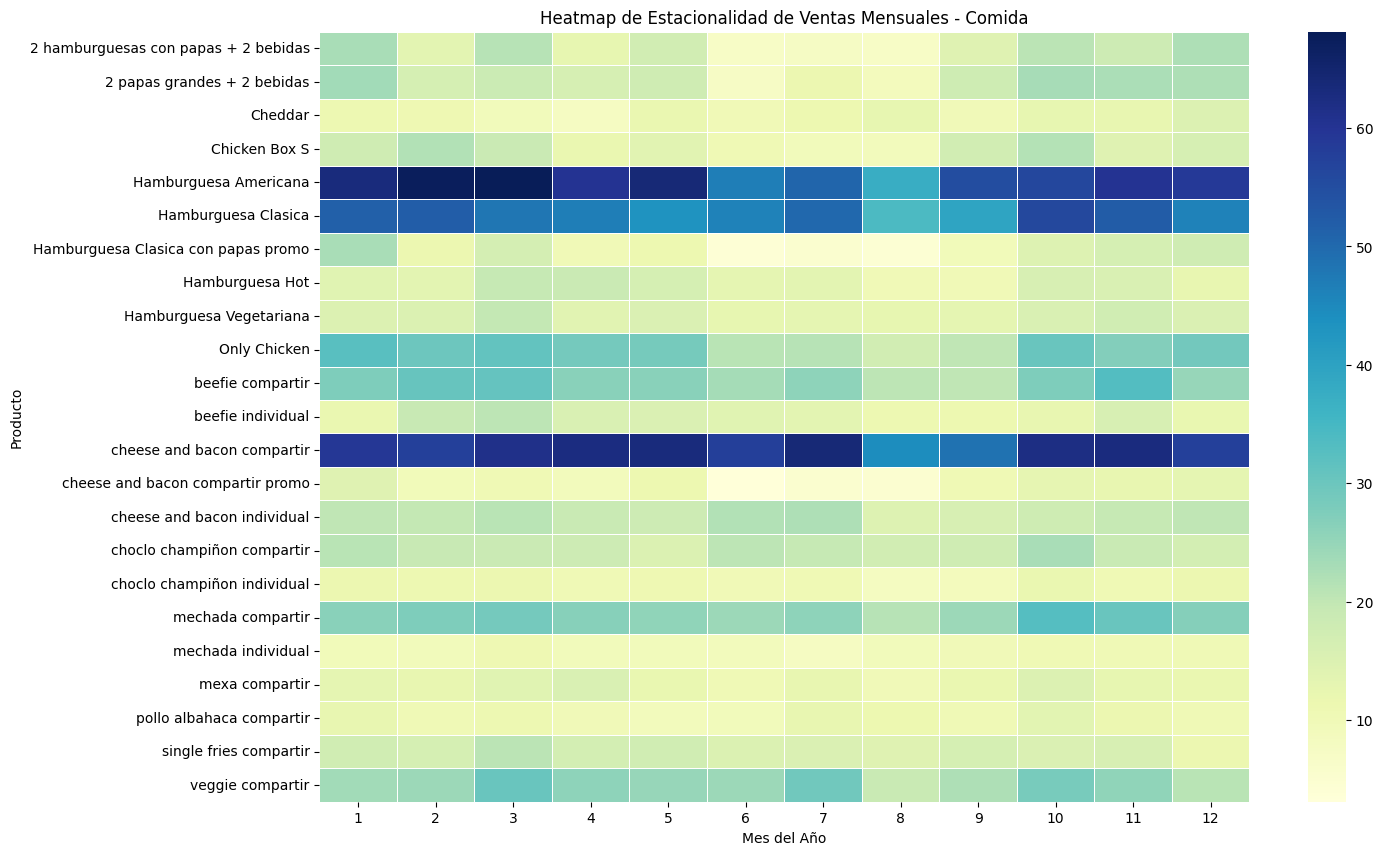

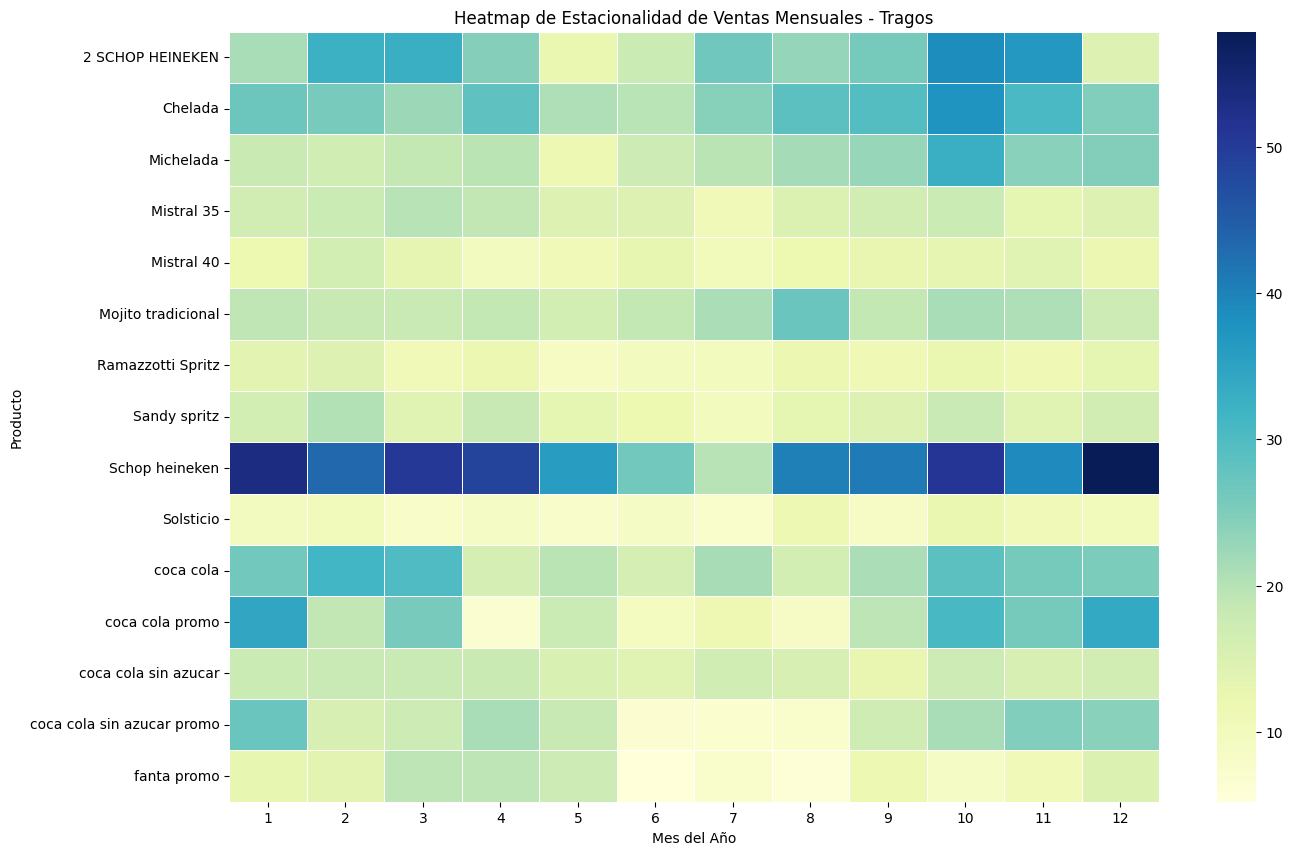

In [55]:
# Agregar la columna 'mes_del_año' a cada DataFrame
df_comida['mes_del_año'] = df_comida['fecha'].dt.month
df_tragos['mes_del_año'] = df_tragos['fecha'].dt.month
# Preparar los datos para los heatmaps mensuales
heatmap_data_comida_mensual = df_comida.groupby(['producto', 'mes_del_año']).ventas_semanales.mean().unstack()
heatmap_data_tragos_mensual = df_tragos.groupby(['producto', 'mes_del_año']).ventas_semanales.mean().unstack()

# Crear los heatmaps mensuales
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_comida_mensual, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Mensuales - Comida')
plt.ylabel('Producto')
plt.xlabel('Mes del Año')

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_tragos_mensual, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Mensuales - Tragos')
plt.ylabel('Producto')
plt.xlabel('Mes del Año')
plt.show()


In [56]:
# Establecer la columna 'fecha' como el índice del dataframe
df.set_index('fecha', inplace=True)

# Reorganizar el dataframe para tener las ventas semanales como columnas separadas
df_pivot = df.pivot_table(index='fecha', columns='producto', values='ventas_semanales', fill_value=0)
# Si hay fechas faltantes, puedes rellenarlas con 0
df_pivot = df_pivot.resample('W').sum().fillna(0)


# Ahora df_pivot está listo para ser utilizado en un modelo SARIMA
df_pivot

producto    2 SCHOP HEINEKEN  2 hamburguesas con papas + 2 bebidas  \
fecha                                                                
2021-08-15                 0                                     4   
2021-08-22                 0                                     0   
2021-08-29                 0                                    11   
2021-09-05                 0                                    20   
2021-09-12                 0                                    34   
...                      ...                                   ...   
2024-01-14                19                                     1   
2024-01-21                 5                                     1   
2024-01-28                 8                                     2   
2024-02-04                20                                     2   
2024-02-11                24                                     1   

producto    2 papas grandes + 2 bebidas  Cheddar  Chelada  Chicken Box S  \
fecha                                                                      
2021-08-15                            3        0        0              1   
2021-08-22                            6        0        0              3   
2021-08-29                            7        4        0             23   
2021-09-05                           24       12        0             40   
2021-09-12                           49       18        0             48   
...                                 ...      ...      ...            ...   
2024-01-14                            5        8       46              0   
2024-01-21                            3        2       36              0   
2024-01-28                            2       12       34              0   
2024-02-04                            8        9       47              1   
2024-02-11                            6        5       50              0   

producto    Hamburguesa Americana  Hamburguesa Clasica  \
fecha                                                    
2021-08-15                      5                    5   
2021-08-22                      4                    2   
2021-08-29                     38                   23   
2021-09-05                     59                   26   
2021-09-12                     59                   50   
...                           ...                  ...   
2024-01-14                     46                   35   
2024-01-21                     42                   26   
2024-01-28                     42                   43   
2024-02-04                     44                   35   
2024-02-11                     40                   28   

producto    Hamburguesa Clasica con papas promo  Hamburguesa Hot  ...  \
fecha                                                             ...   
2021-08-15                                    1                0  ...   
2021-08-22                                    0                0  ...   
2021-08-29                                    8                1  ...   
2021-09-05                                   15                6  ...   
2021-09-12                                   25               11  ...   
...                                         ...              ...  ...   
2024-01-14                                    0                5  ...   
2024-01-21                                    0                8  ...   
2024-01-28                                    1               13  ...   
2024-02-04                                    1                7  ...   
2024-02-11                                    1                8  ...   

producto    coca cola promo  coca cola sin azucar  coca cola sin azucar promo  \
fecha                                                                           
2021-08-15                4                     0                           4   
2021-08-22                4                     3                           3   
2021-08-29                5                     5                      

In [57]:
# df_pivot.to_csv("./archivos_csv/pivot.csv", index=False)

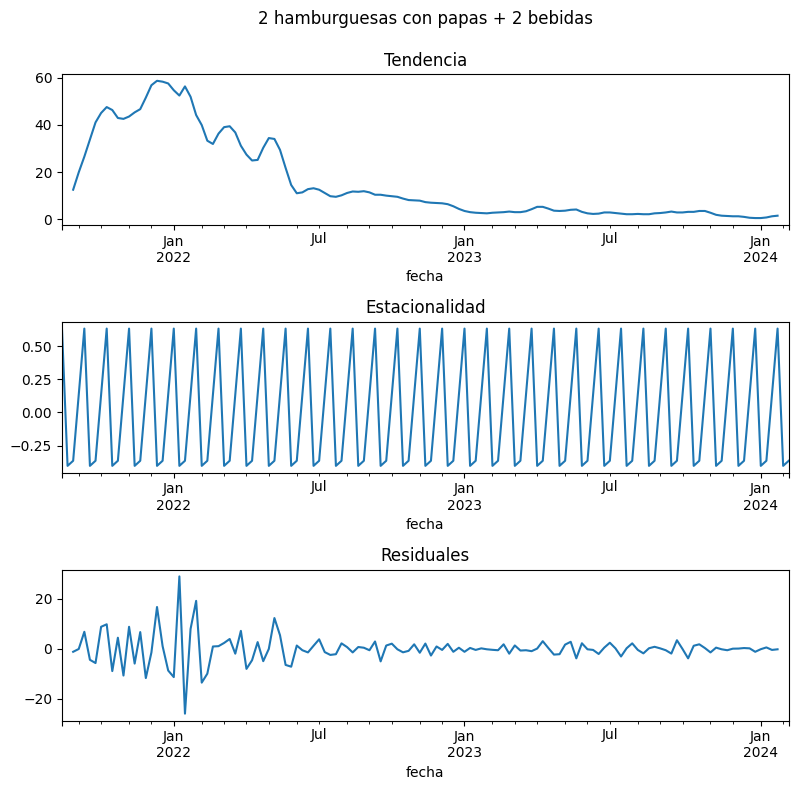

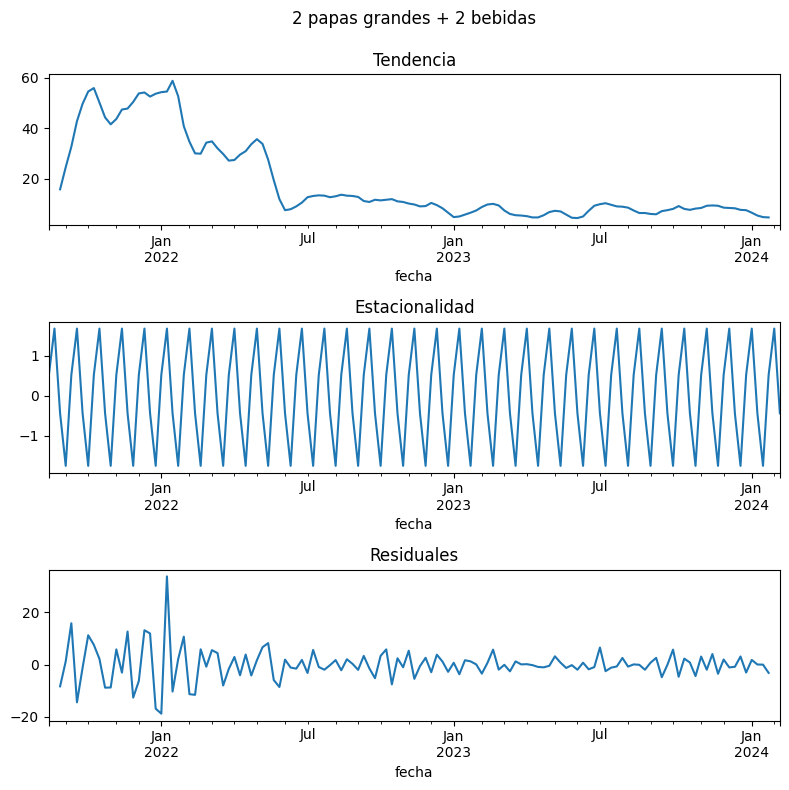

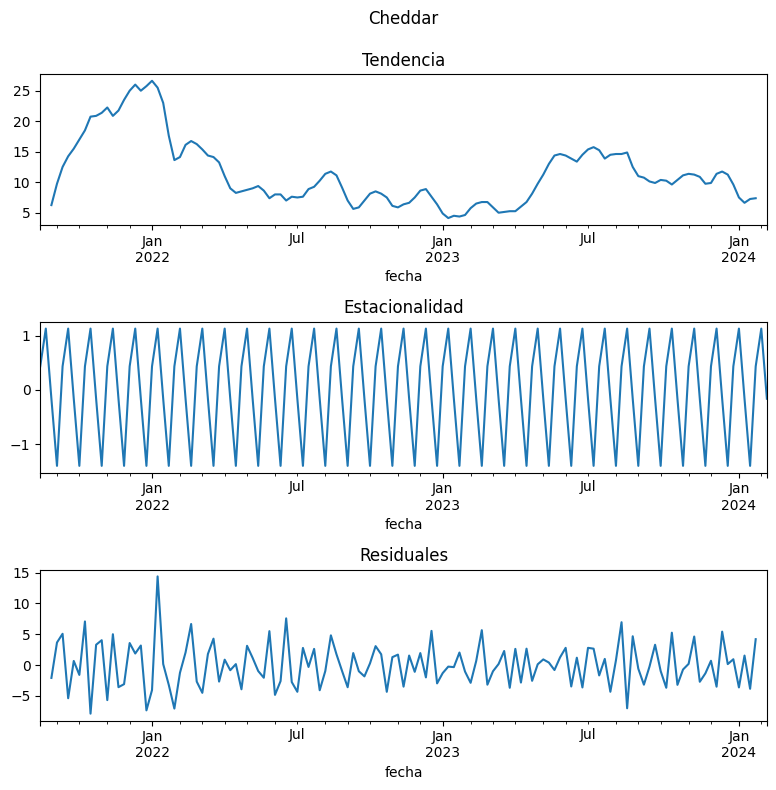

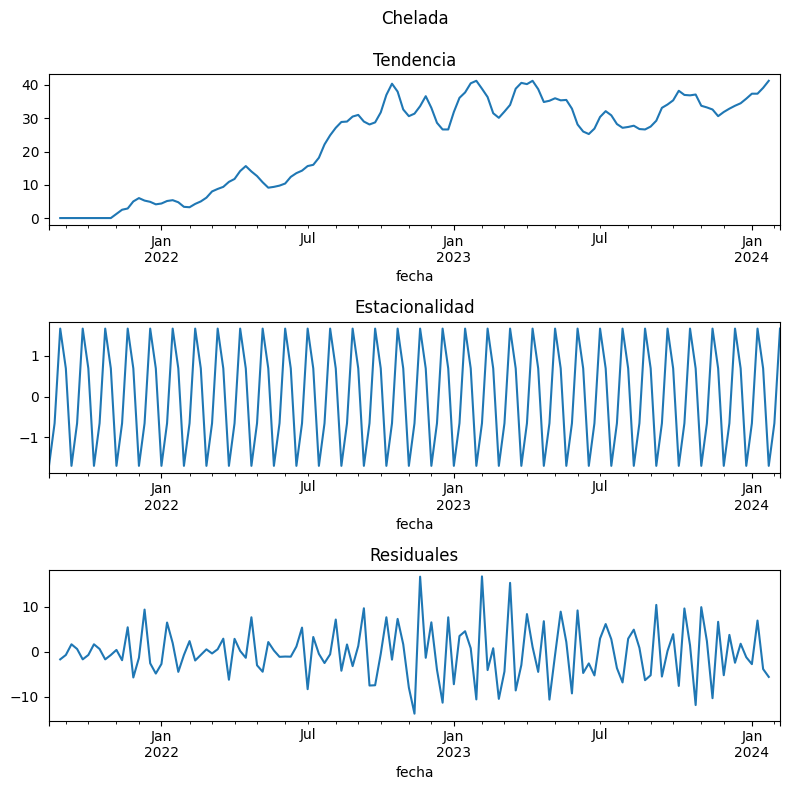

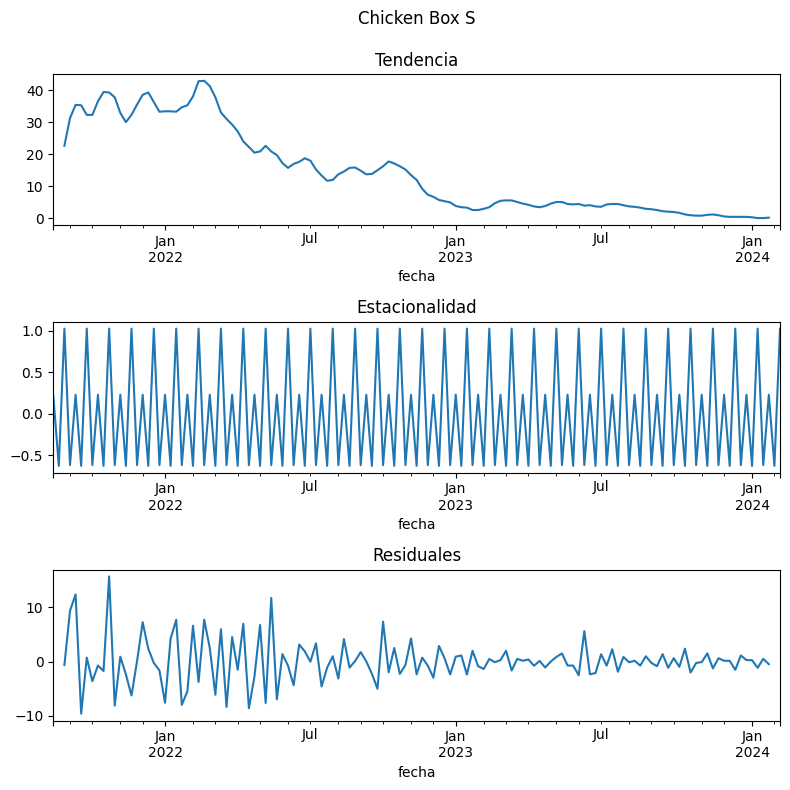

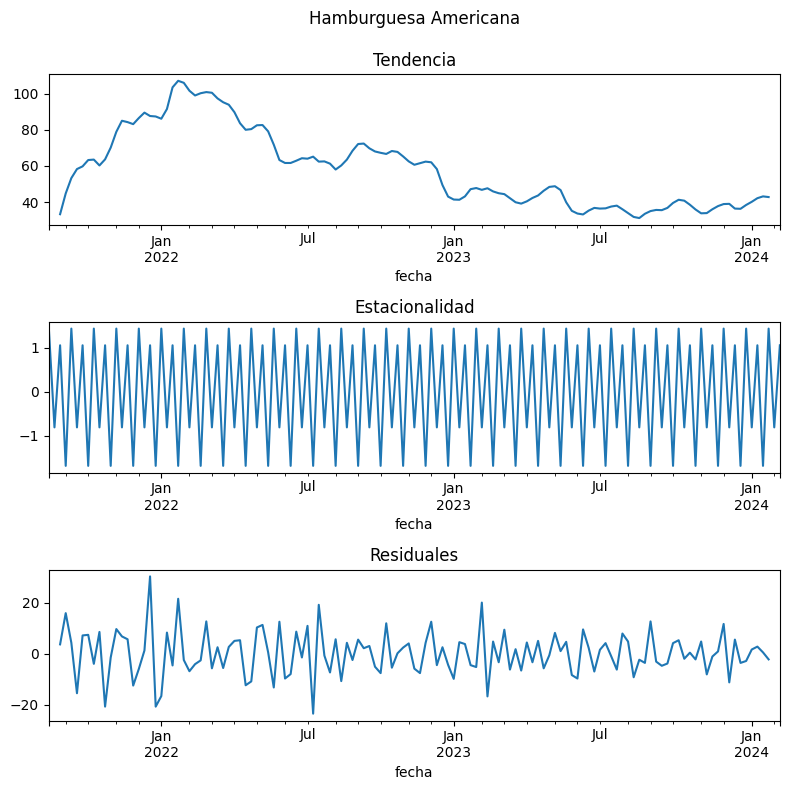

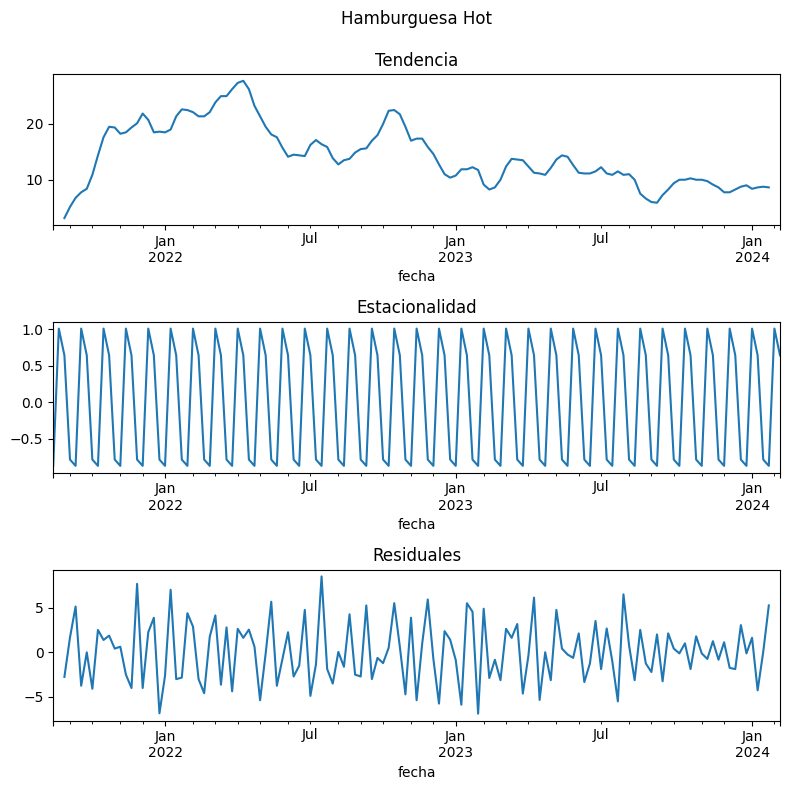

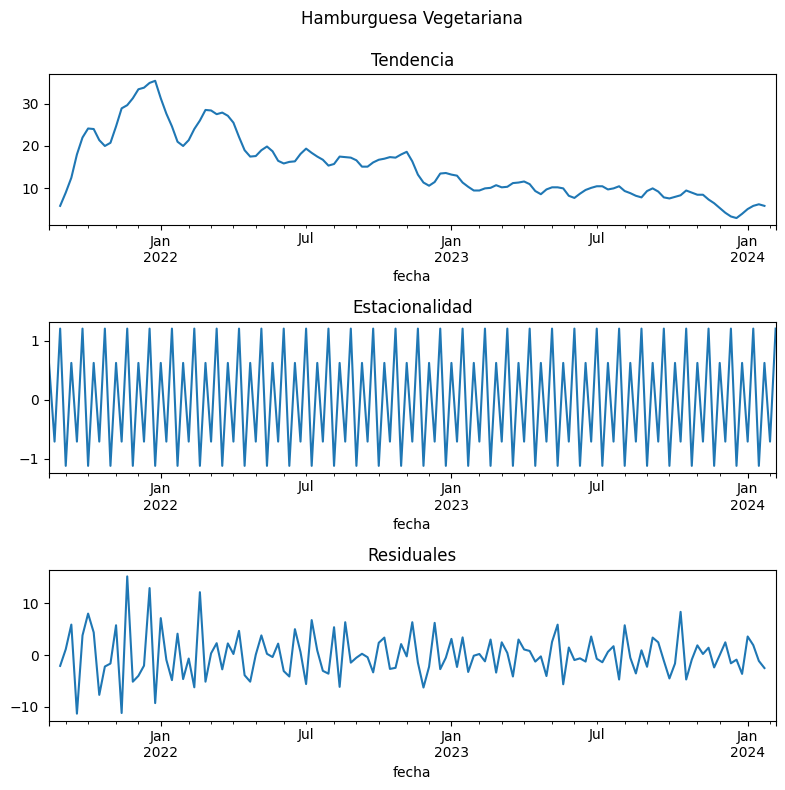

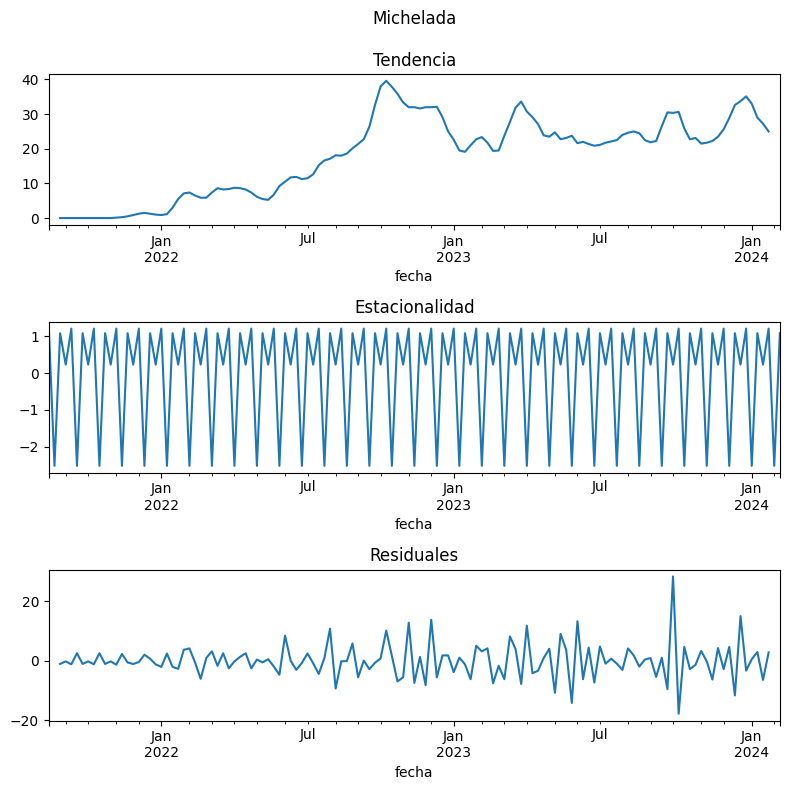

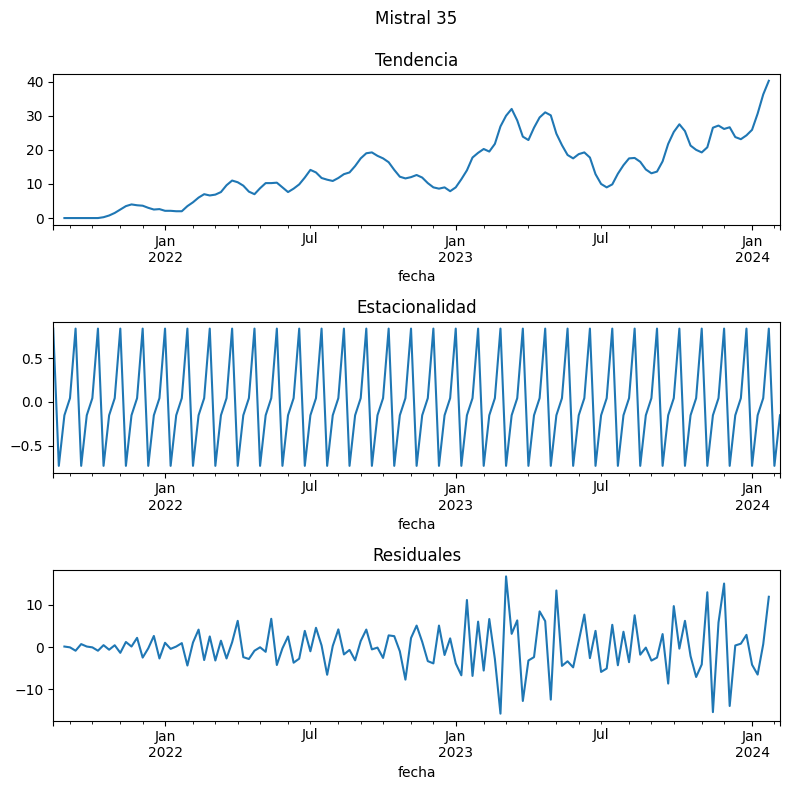

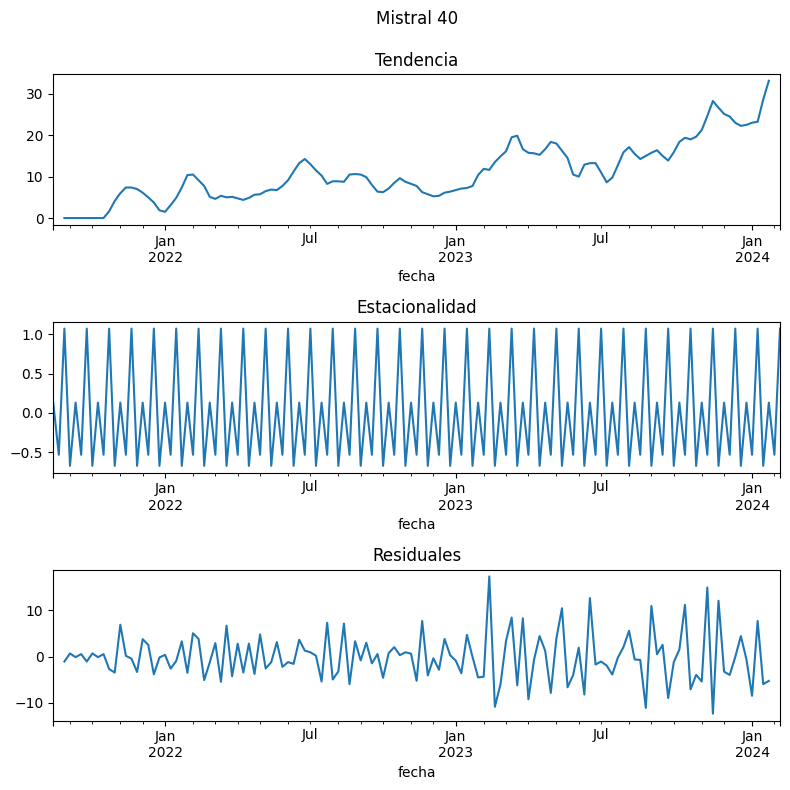

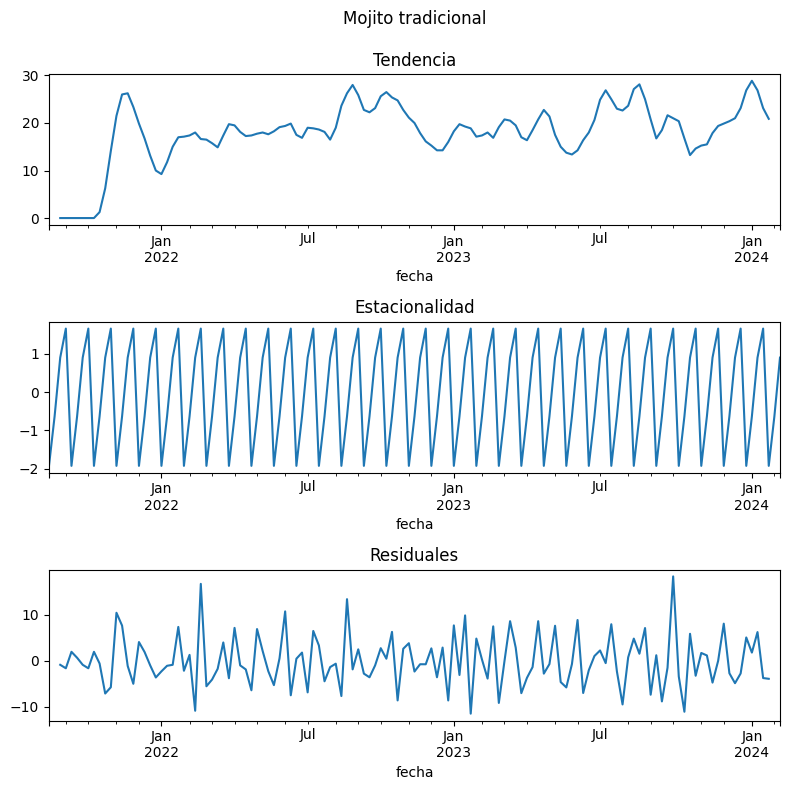

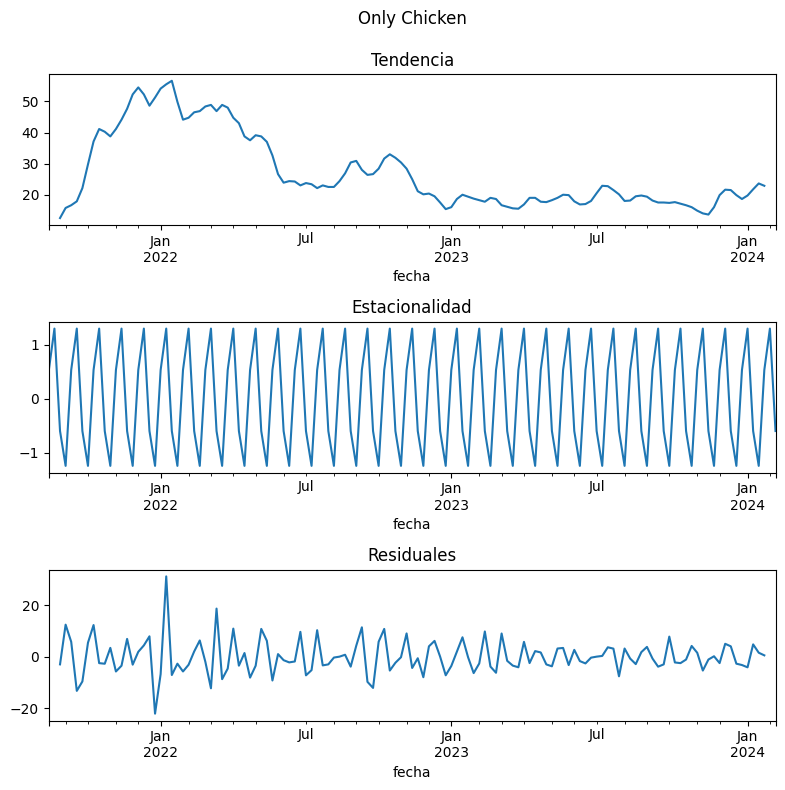

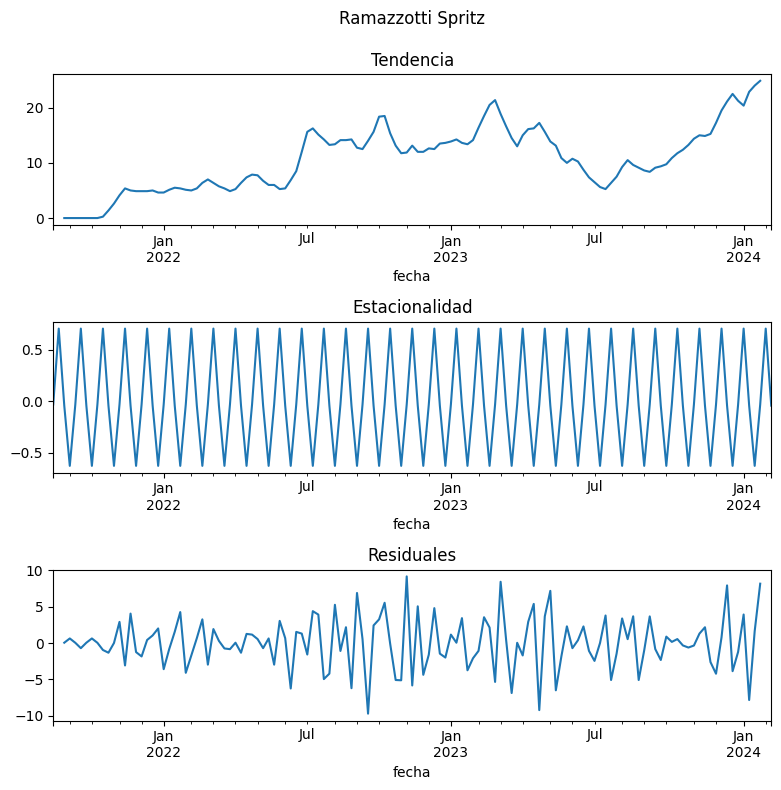

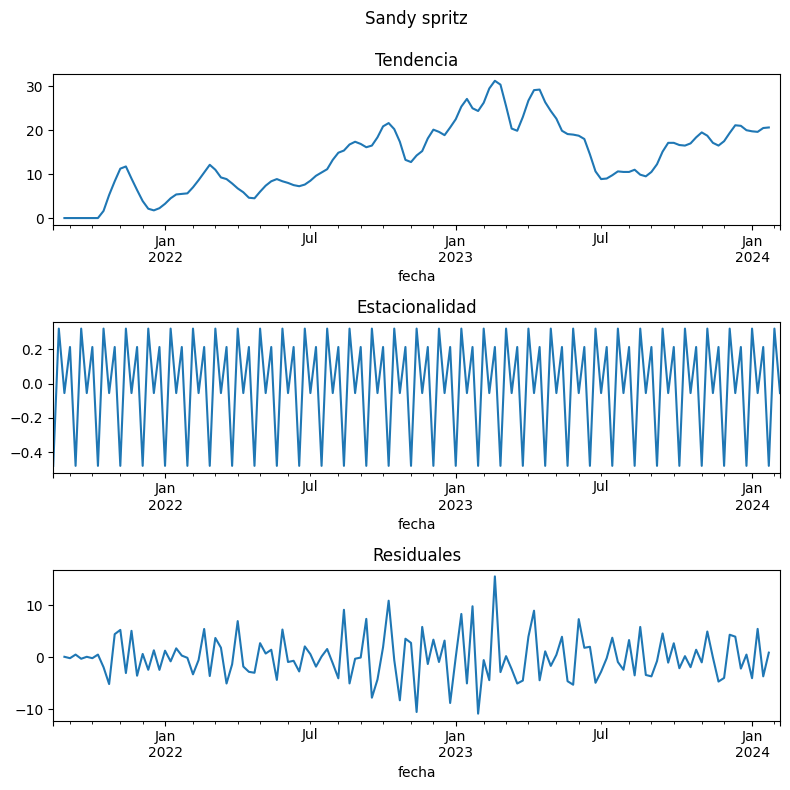

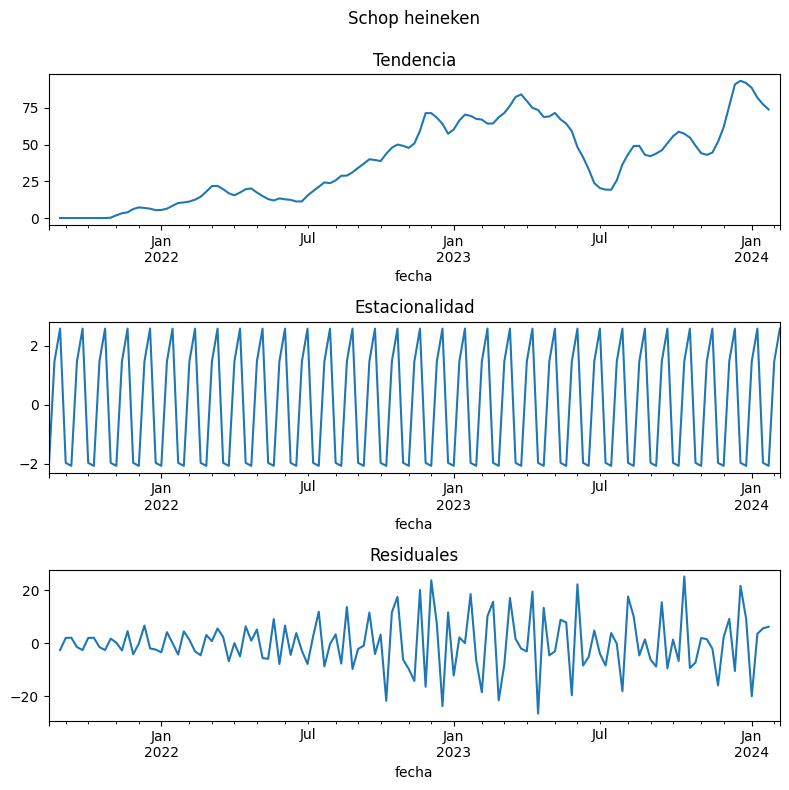

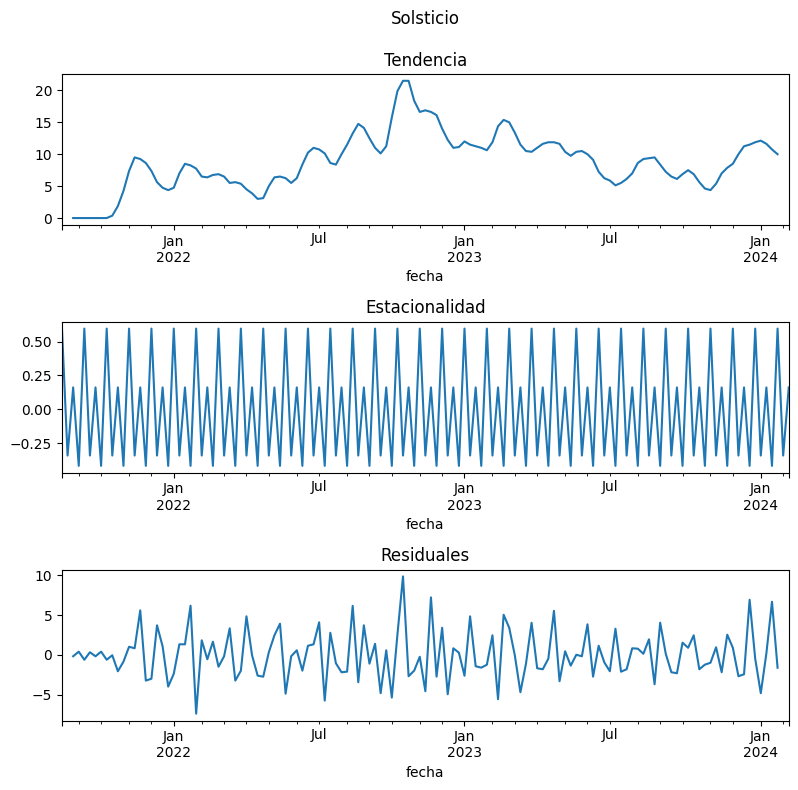

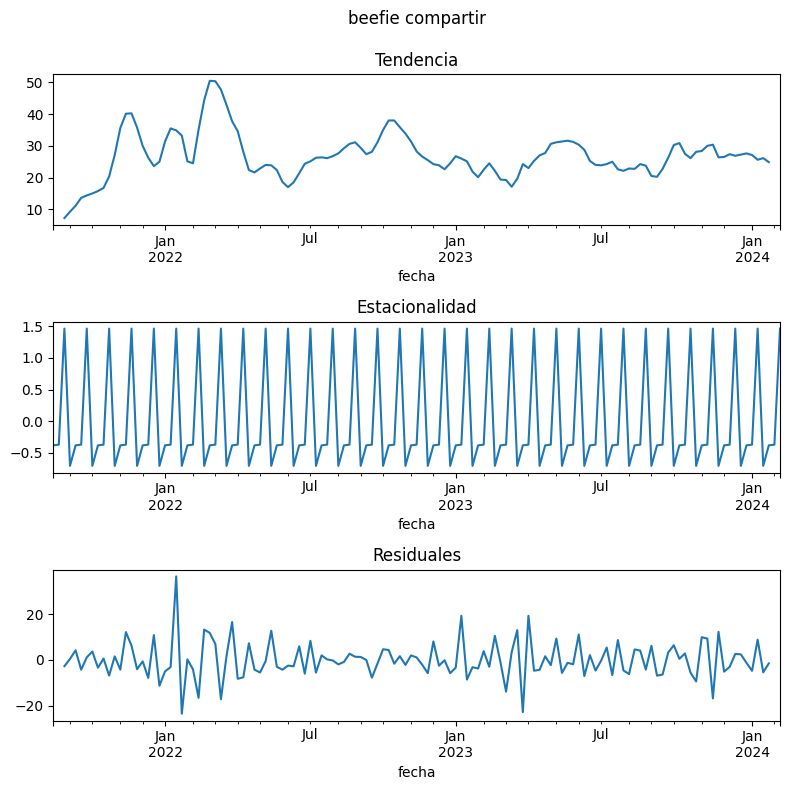

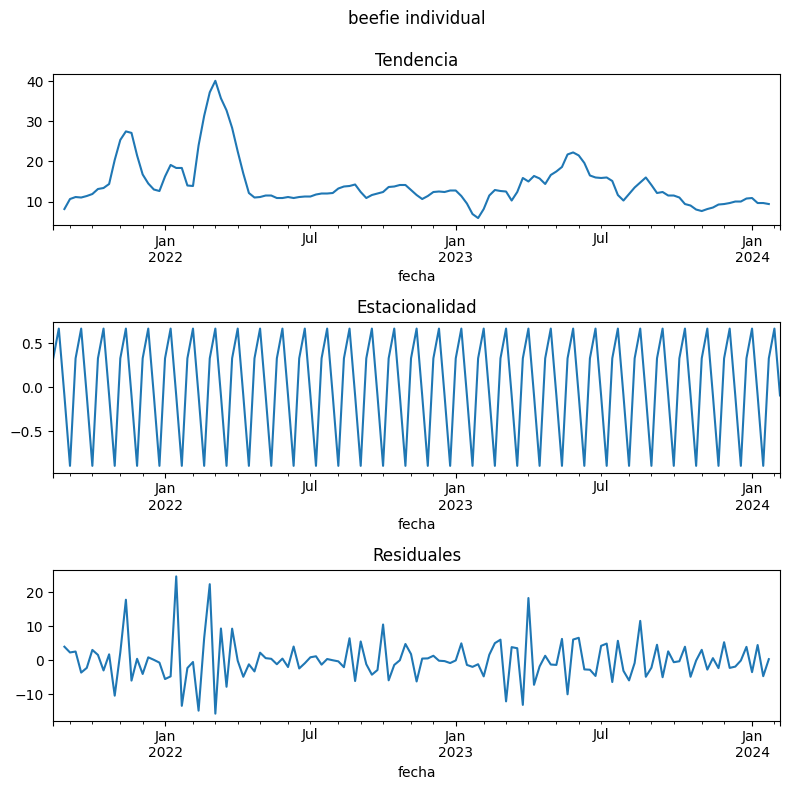

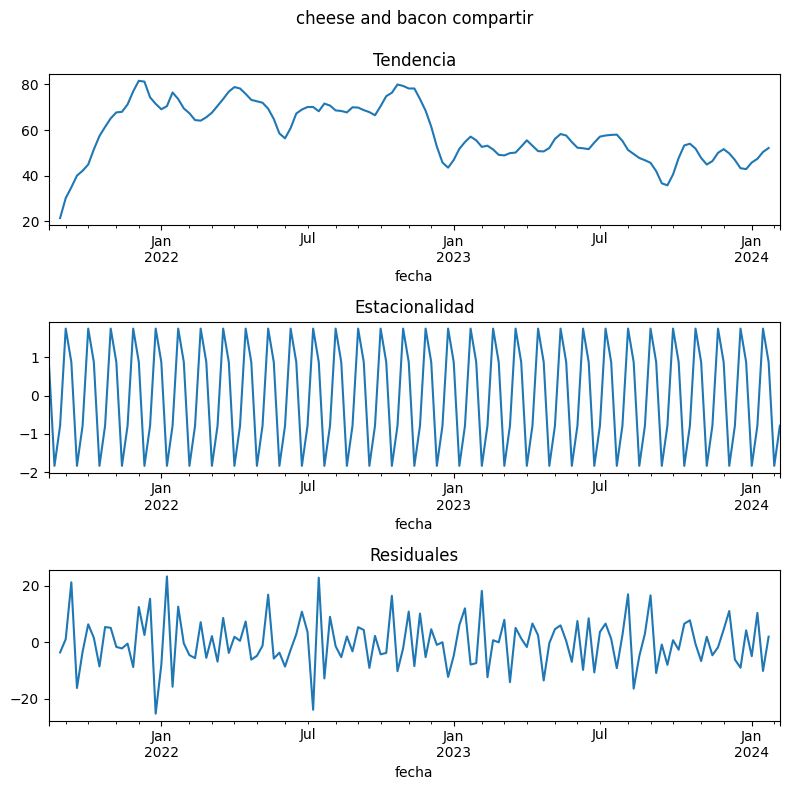

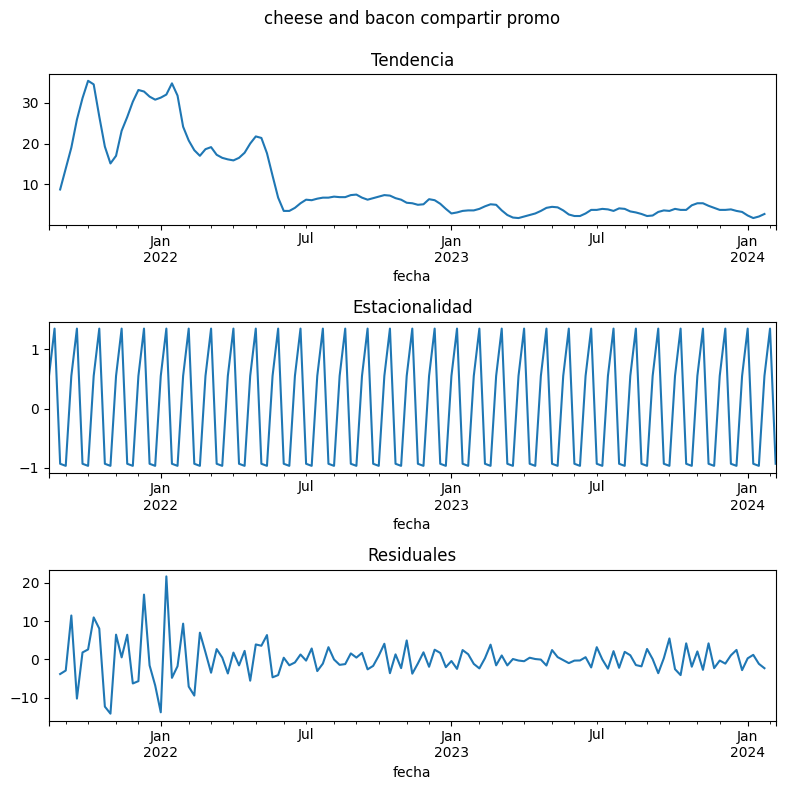

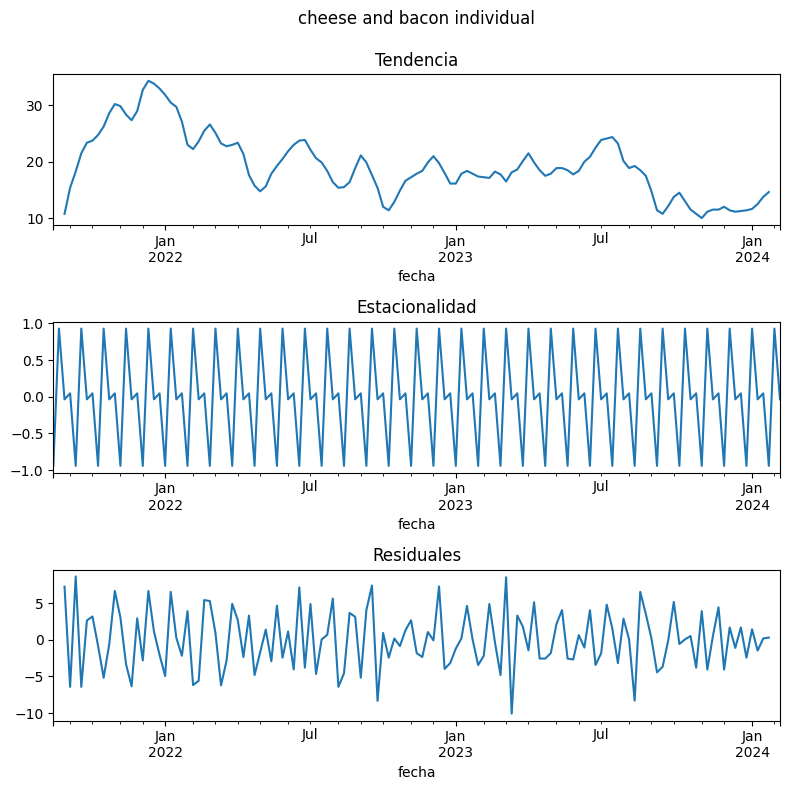

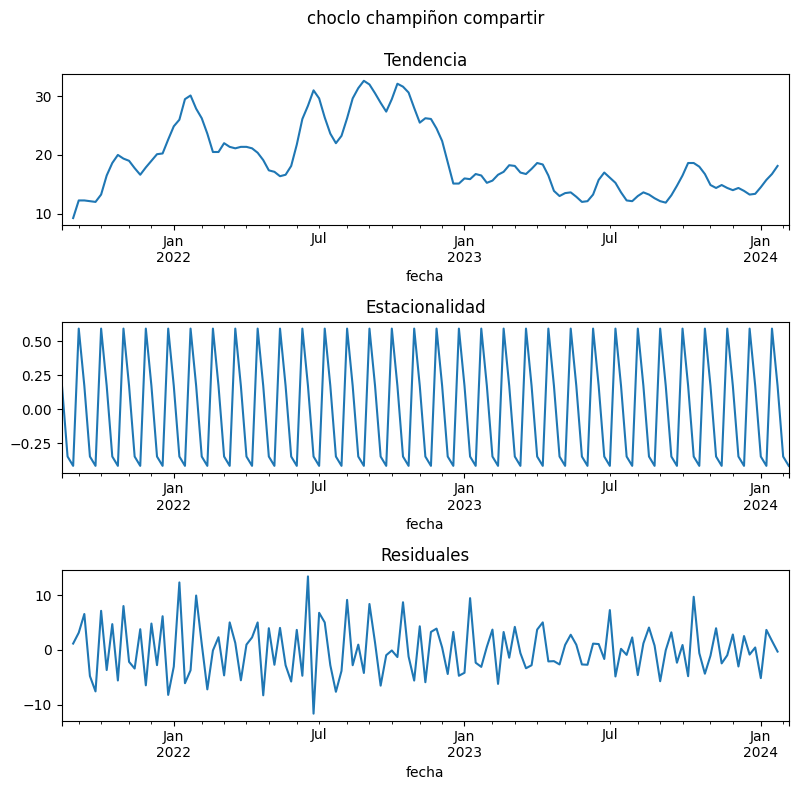

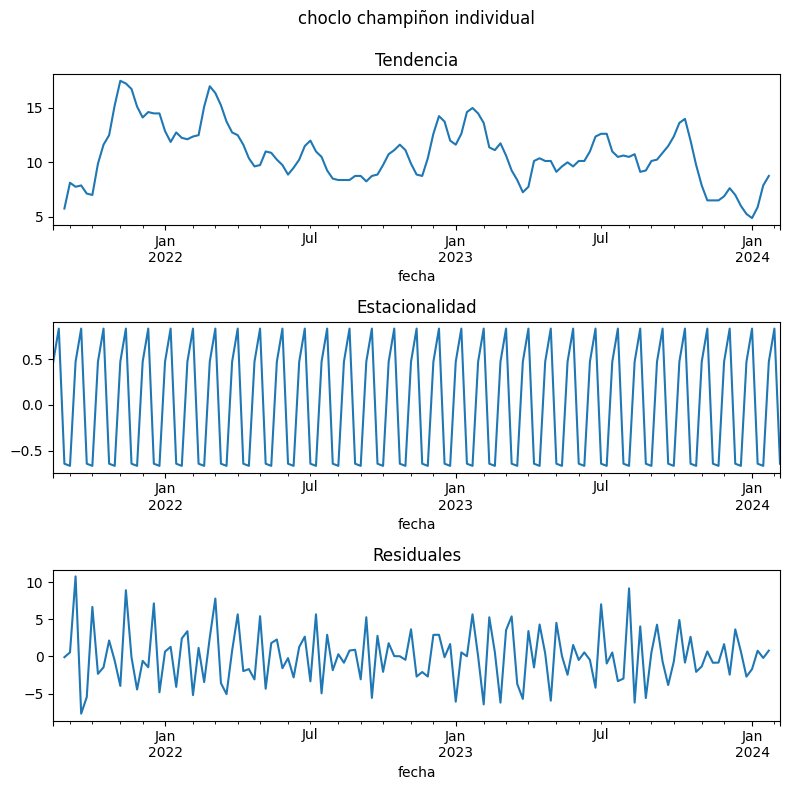

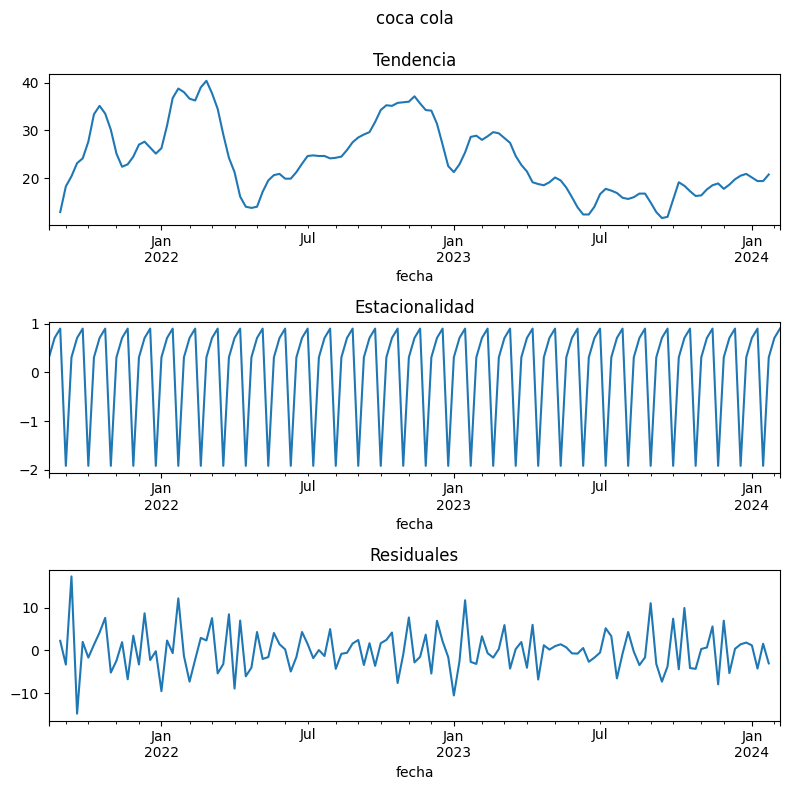

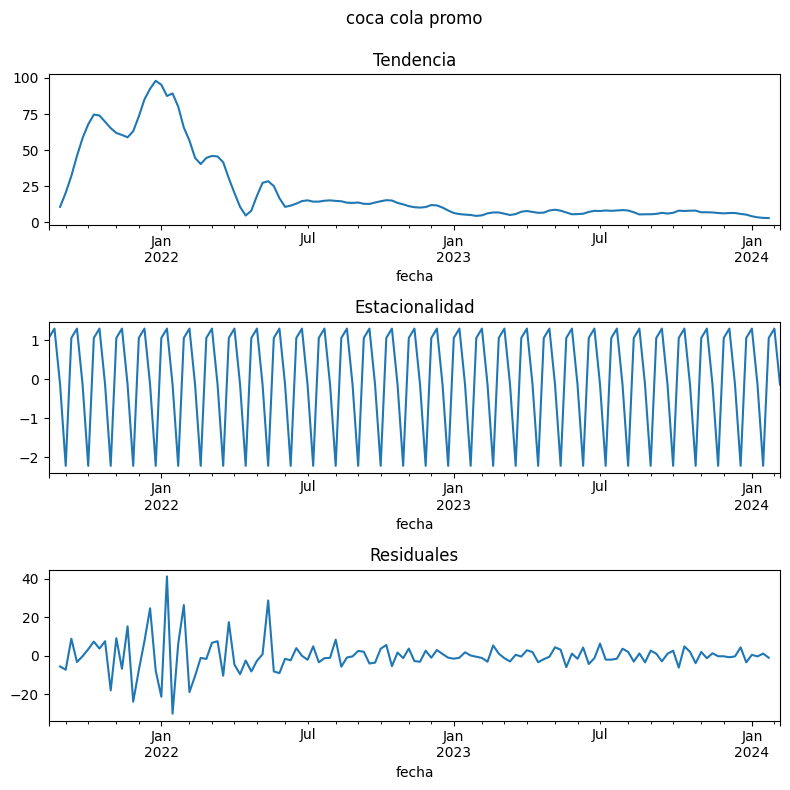

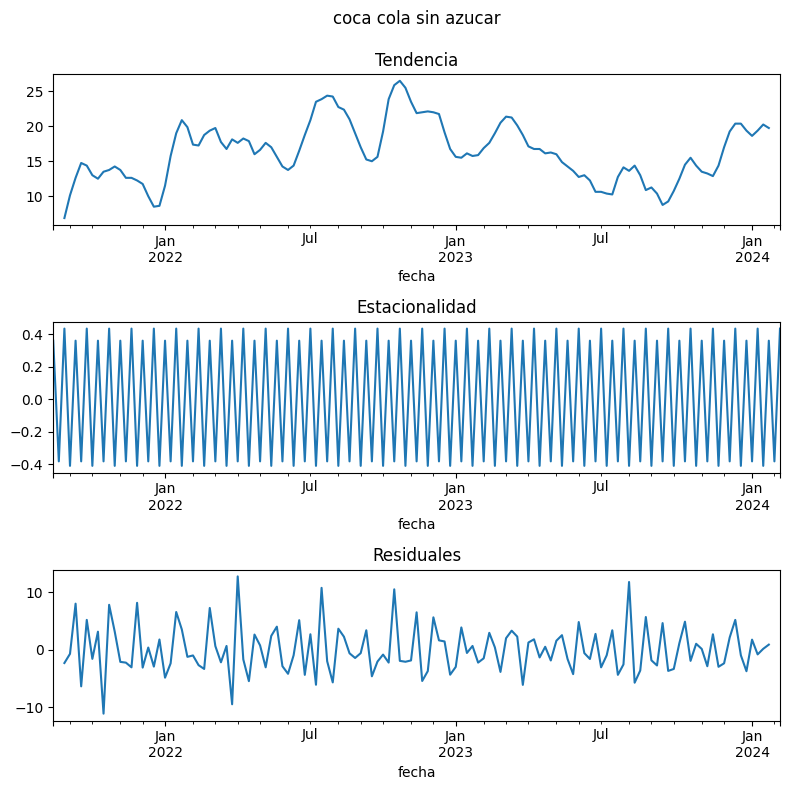

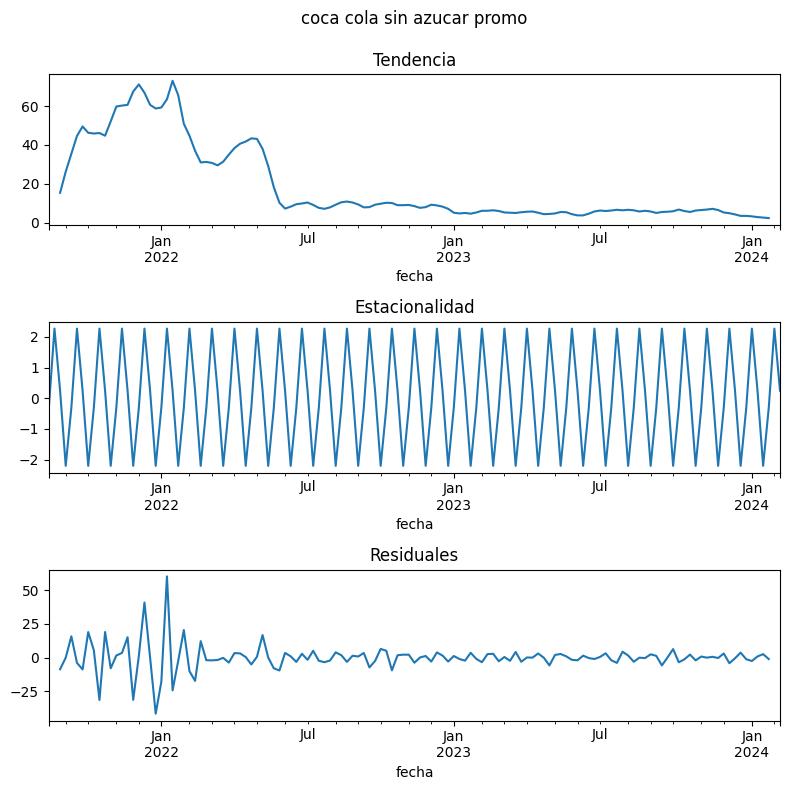

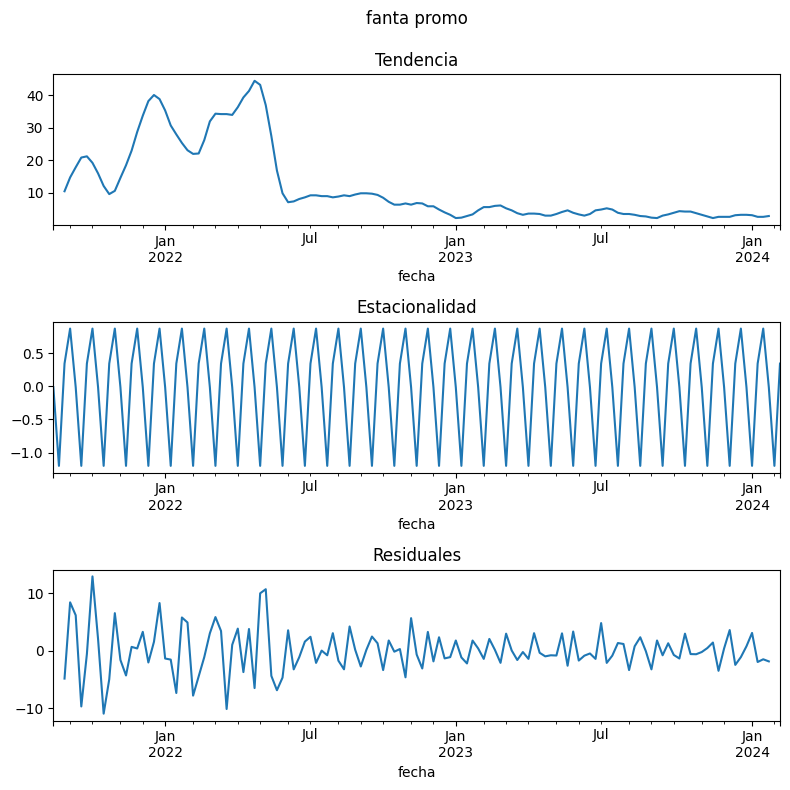

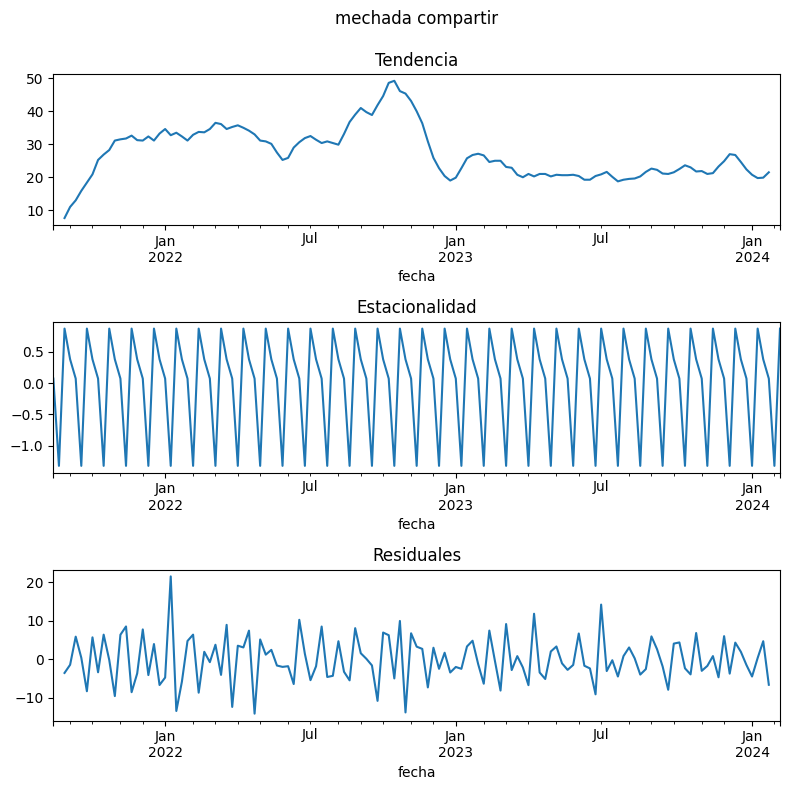

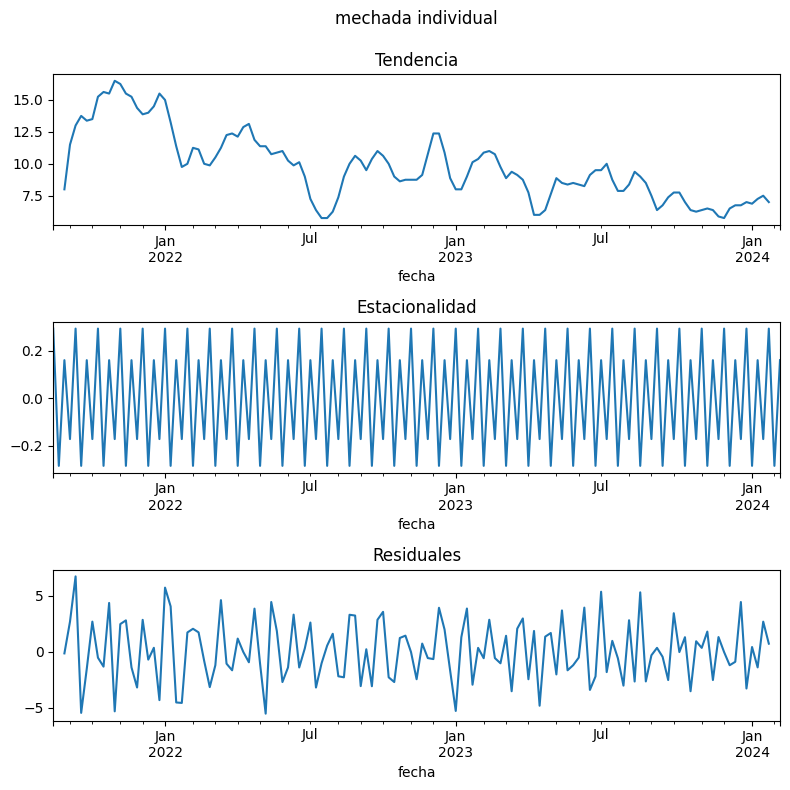

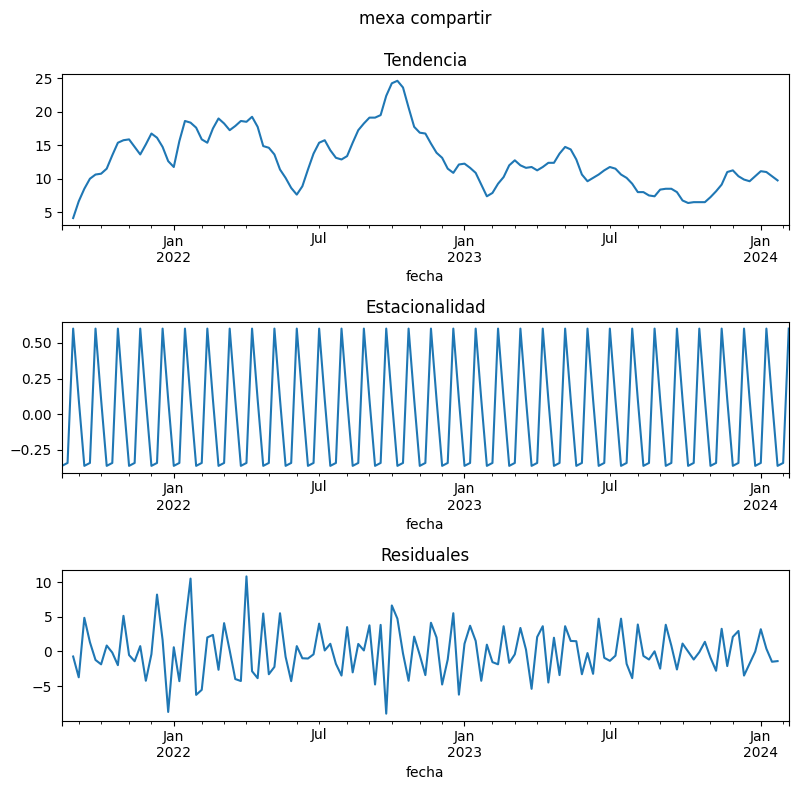

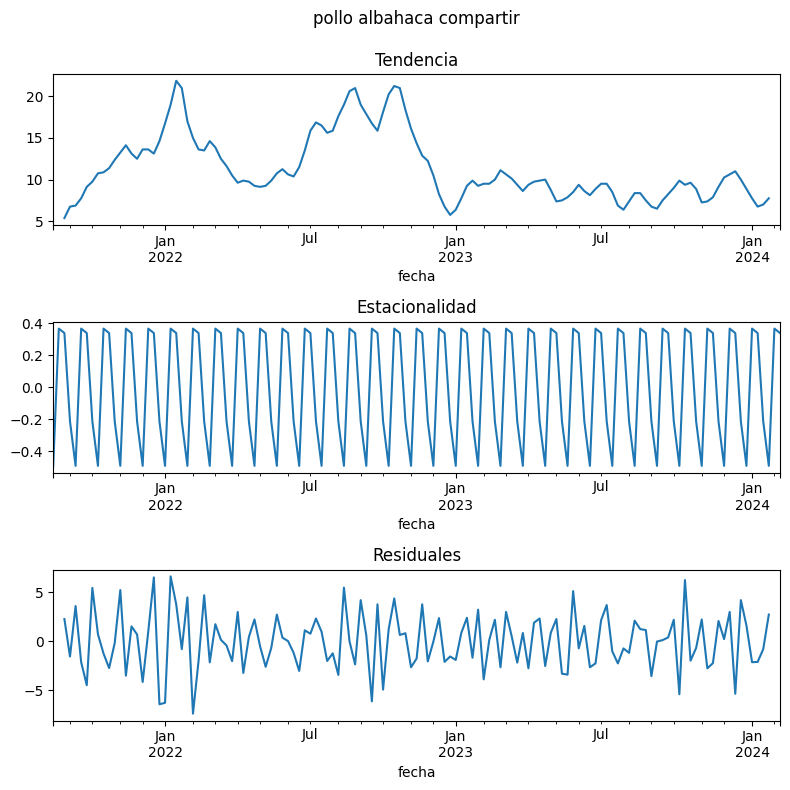

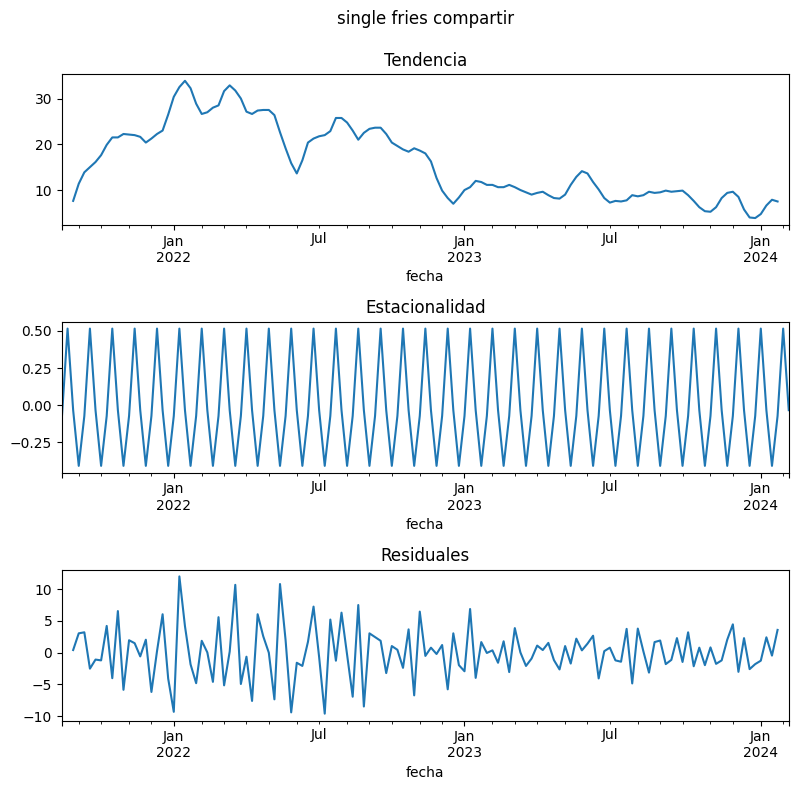

In [58]:
for product in df_pivot.columns[:-1]:
    # Decomposing
    decomposed = seasonal_decompose(df_pivot[product], model='additive', period=4)  # period=4 para patrones mensuales

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    plt.title(f'{product}\n\nTendencia')  
    decomposed.trend.plot()

    plt.subplot(312)
    plt.title('Estacionalidad')
    decomposed.seasonal.plot()

    plt.subplot(313)
    plt.title('Residuales')
    decomposed.resid.plot()

    plt.tight_layout()
    plt.show()

    print("\n")

Hemos observado que existe estacionalidad mensualmente, hay un comportamiento que se repite mensualmente para cada producto, como estamos trabajando como diversos productos, no podemos capturar detalladamente el comportamiento. Incluiremos en nuestro modelo el ujuste del parametro 'm' para modelos autorima donde podremos especificar el numero para el cual encontramos tendencia. 

In [61]:
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = data[0:-n_test], data[-n_test:]
    history = [x for x in train]
    
    for i in range(len(test)):
        model = auto_arima(history, seasonal=True, m=4, stepwise=True, suppress_warnings=True, 
                           error_action="ignore", max_order=None, trace=False)
        yhat = model.predict(n_periods=1)[0]
        predictions.append(yhat)
        history.append(test[i])  # Agrega observaciones al entrenamiento para el próximo ciclo.
    
    error = np.sqrt(mean_squared_error(test, predictions))
    return error, test, predictions, model

resultados_rmse_wf= {}
modelos_entrenados = {}

# Ajuste de la cantidad de datos de prueba para la validación cruzada
n_test = 5  # Ejemplo: usar los últimos 5 puntos para la prueba

for producto in df_pivot.columns:
    serie_temporal = df_pivot[producto].dropna()
    
    # Aplicar validación cruzada "walk-forward"
    error, test, predictions, model = walk_forward_validation(serie_temporal, n_test)
    
    # Almacenar el modelo entrenado
    modelos_entrenados[producto] = model
    
    # Guardar el modelo como un archivo pickle
    filename = f'{producto}'
    with open(filename, 'wb') as archivo_salida:
        pickle.dump(model, archivo_salida)
    # Almacenar el error RMSE
    
    resultados_rmse_wf[producto] = error
    
    # Imprimir el RMSE para cada producto
    print(f"RMSE de validación cruzada para {producto}: {error:.3f}")
    
    # Fechas para el eje x
    fechas = serie_temporal.index[-n_test:]
    
    plt.figure(figsize=(10, 6))
    plt.plot(fechas, test, marker='o', label='Real')
    plt.plot(fechas, predictions, marker='x', linestyle='--', label='Pronóstico')
    plt.title(f'Validación Cruzada Walk-Forward para {producto}')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.legend()
    plt.xticks(rotation=45)  
    plt.tight_layout()
    plt.show()

NameError: name 'pickle' is not defined

Crearemos una funcion que permita seleccionar el producto y la fecha para ver su predicción, como los datos reales son hasta febrero, recomendamos hacer predicciones hasta mayo para mayor precesión, ya que al no tener actualización de datos las predicciones hasta más adelante se basan en predicciones donde no hay datos. 

In [29]:
def predict_for_specific_date(product, target_date, df_pivot, modelos_entrenados):
    if product not in df_pivot.columns:
        print("Producto no encontrado.")
        return None
    
    model = modelos_entrenados.get(product)
    
    if model is None:
        print("No se encontró un modelo entrenado para este producto.")
        return None

    target_date = pd.to_datetime(target_date)
    last_known_data = df_pivot[product].dropna()
    last_known_date = last_known_data.index[-1]

    if target_date <= last_known_date:
        print("La fecha objetivo debe ser posterior a la última fecha conocida en los datos.")
        return None

    periods_ahead = (target_date - last_known_date).days // 7

    # Asumiendo que los datos son semanales, ajustamos la serie temporal
    future_data = last_known_data.copy()
    for i in range(periods_ahead):
        # Entrenar el modelo con los datos actuales
        model = auto_arima(future_data, seasonal=True, m=4, stepwise=True, suppress_warnings=True,
                           error_action="ignore", max_order=None, trace=False)

        # Predecir el siguiente punto
        next_prediction = model.predict(n_periods=1)[0]

        # Actualizar los datos históricos con la nueva predicción
        new_index = future_data.index[-1] + pd.DateOffset(weeks=1)
        future_data = pd.concat([future_data, pd.Series([next_prediction], index=[new_index])])

    prediction_for_target_date = future_data.iloc[-1]
    return prediction_for_target_date

# Ajustar a fin de semana
def adjust_to_week_end(target_date, last_known_date):
    day_of_week = last_known_date.weekday()
    adjusted_date = target_date + pd.Timedelta(days=(6-day_of_week))
    return adjusted_date

producto_seleccionado = 'Hamburguesa Clasica'  # Asegúrate de que este producto esté en df_pivot.columns
fecha_objetivo = '2024-03-05'  # La fecha para la cual quieres la predicción

# Asegúrate de que df_pivot y modelos_entrenados están definidos y contienen los datos/modelos correctos
prediccion = predict_for_specific_date(producto_seleccionado, fecha_objetivo, df_pivot, modelos_entrenados)

print(f"La predicción ajustada al final de la semana para {producto_seleccionado} en {fecha_objetivo} es: {ceil(prediccion)}")


La predicción ajustada al final de la semana para Hamburguesa Clasica en 2024-03-05 es: 32


In [30]:
producto_seleccionado = 'Hamburguesa Clasica'  # Asegúrate de que este producto esté en df_pivot.columns
fecha_objetivo = '2024-07-05'  # La fecha para la cual quieres la predicción

# Asegúrate de que df_pivot y modelos_entrenados están definidos y contienen los datos/modelos correctos
prediccion = predict_for_specific_date(producto_seleccionado, fecha_objetivo, df_pivot, modelos_entrenados)

print(f"La predicción ajustada al final de la semana para {producto_seleccionado} en {fecha_objetivo} es: {ceil(prediccion)}")

La predicción ajustada al final de la semana para Hamburguesa Clasica en 2024-07-05 es: 33
